In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import pyqg

import sys; sys.path.append('..')
from pyqg_subgrid_dataset import PYQGSubgridDataset
from models import *

In [21]:
class BasicScaler(object):
    def __init__(self, mu=0, sd=1):
        self.mu = mu
        self.sd = sd
    
    def fit(self, x):
        assert(len(x.shape)==2)
        self.mu = np.mean(x)
        self.sd = np.std(x)
        
    def transform(self, x):
        return (x - self.mu) / self.sd
    
    def inverse_transform(self, z):
        return z * self.sd + self.mu

In [2]:
class LargerCNN(nn.Sequential, ScaledModel):
    def __init__(self, input_shape, output_shape, pad='circular'):
        conv = nn.Sequential(OrderedDict([
            ('unflatten', nn.Unflatten(1, input_shape)),

            ('conv1', nn.Conv2d(input_shape[0], 64, 5, padding_mode=pad)),
            ('norm1', nn.BatchNorm2d(64)),
            ('relu1', nn.ReLU()),
            ('pool1', nn.MaxPool2d(2)),

            ('conv2', nn.Conv2d(64, 32, 5, padding_mode=pad)),
            ('norm2', nn.BatchNorm2d(32)),
            ('relu2', nn.ReLU()),
            ('pool2', nn.MaxPool2d(2)),

            ('flat', nn.Flatten())
        ]))
        fc_size = conv(torch.rand(2,np.product(input_shape))).shape[1]
        super().__init__(OrderedDict([
            ('conv', conv),
            ('fc1', nn.Linear(fc_size, 256)),
            ('relu', nn.ReLU()),
            ('fc2', nn.Linear(256, np.product(output_shape)))
        ]))

In [3]:
ds = PYQGSubgridDataset(data_dir='/scratch/zanna/data/pyqg/many_runs_few_steps_irregular')
ds.dataset

Struct(config={'n_runs': 1000, 'scale_factor': 2, 'pyqg_kwargs': {'tmax': 311040000.0, 'twrite': 10000, 'tavestart': 155520000.0}, 'sampling_freq': 1000, 'sampling_mode': 'exponential', 'sampling_delay': 0}, order=array([61301, 52391, 58576, ..., 42613, 43567, 68268]), layer_idxs=array([0, 1, 0, ..., 1, 0, 1]), forcing_data=<xarray.Dataset>
Dimensions:              (batch: 87386, x: 32, y: 32)
Coordinates:
  * x                    (x) float64 1.562e+04 4.688e+04 ... 9.531e+05 9.844e+05
  * y                    (y) float64 1.562e+04 4.688e+04 ... 9.531e+05 9.844e+05
Dimensions without coordinates: batch
Data variables:
    x_velocity           (batch, x, y) float64 ...
    y_velocity           (batch, x, y) float64 ...
    potential_vorticity  (batch, x, y) float64 ..., time_idxs=array([  630,   630,  2912, ..., 41462, 42614, 42614]), run_idxs=array([  0,   0,   0, ..., 999, 999, 999]), time_vals=array([4.543200e+06, 4.543200e+06, 2.097360e+07, ..., 2.985336e+08,
       3.068280e+08, 3.

In [4]:
u = ds.dataset.coarse_data.x_velocity[::2]
v = ds.dataset.coarse_data.y_velocity[::2]
q = ds.dataset.coarse_data.potential_vorticity[::2]

In [61]:
u2 = ds.dataset.coarse_data.x_velocity[1:][::2]
v2 = ds.dataset.coarse_data.y_velocity[1:][::2]
q2 = ds.dataset.coarse_data.potential_vorticity[1:][::2]

In [5]:
ds.dataset.layer_idxs

array([0, 1, 0, ..., 1, 0, 1])

In [72]:
np.argwhere(ds.dataset.layer_idxs==0)[:,0]

array([    0,     2,     4, ..., 87380, 87382, 87384])

In [6]:
#Su = ds.dataset.forcing_data4.x_velocity[::2]
Sv = ds.dataset.forcing_data.y_velocity[::2]
Sq = ds.dataset.forcing_data.potential_vorticity[::2]

In [62]:
Sv2 = ds.dataset.forcing_data.y_velocity[1:][::2]
Sq2 = ds.dataset.forcing_data.potential_vorticity[1:][::2]

In [8]:
matplotlib.rcParams.update({ 'font.size': 10 })

In [9]:
uv = np.array([
    [u[i], v[i]] for i in range(len(u))
])
uv.shape

(43693, 2, 32, 32)

In [63]:
uv2 = np.array([
    [u2[i], v2[i]] for i in range(len(u2))
])
uv2.shape

(43693, 2, 32, 32)

In [44]:
#X = uv.astype(np.float32).reshape(-1, 2*32*32)
X = uv.astype(np.float32).reshape(-1, 2*32*32)
Y = Sq.data.astype(np.float32).reshape(-1, 32*32)

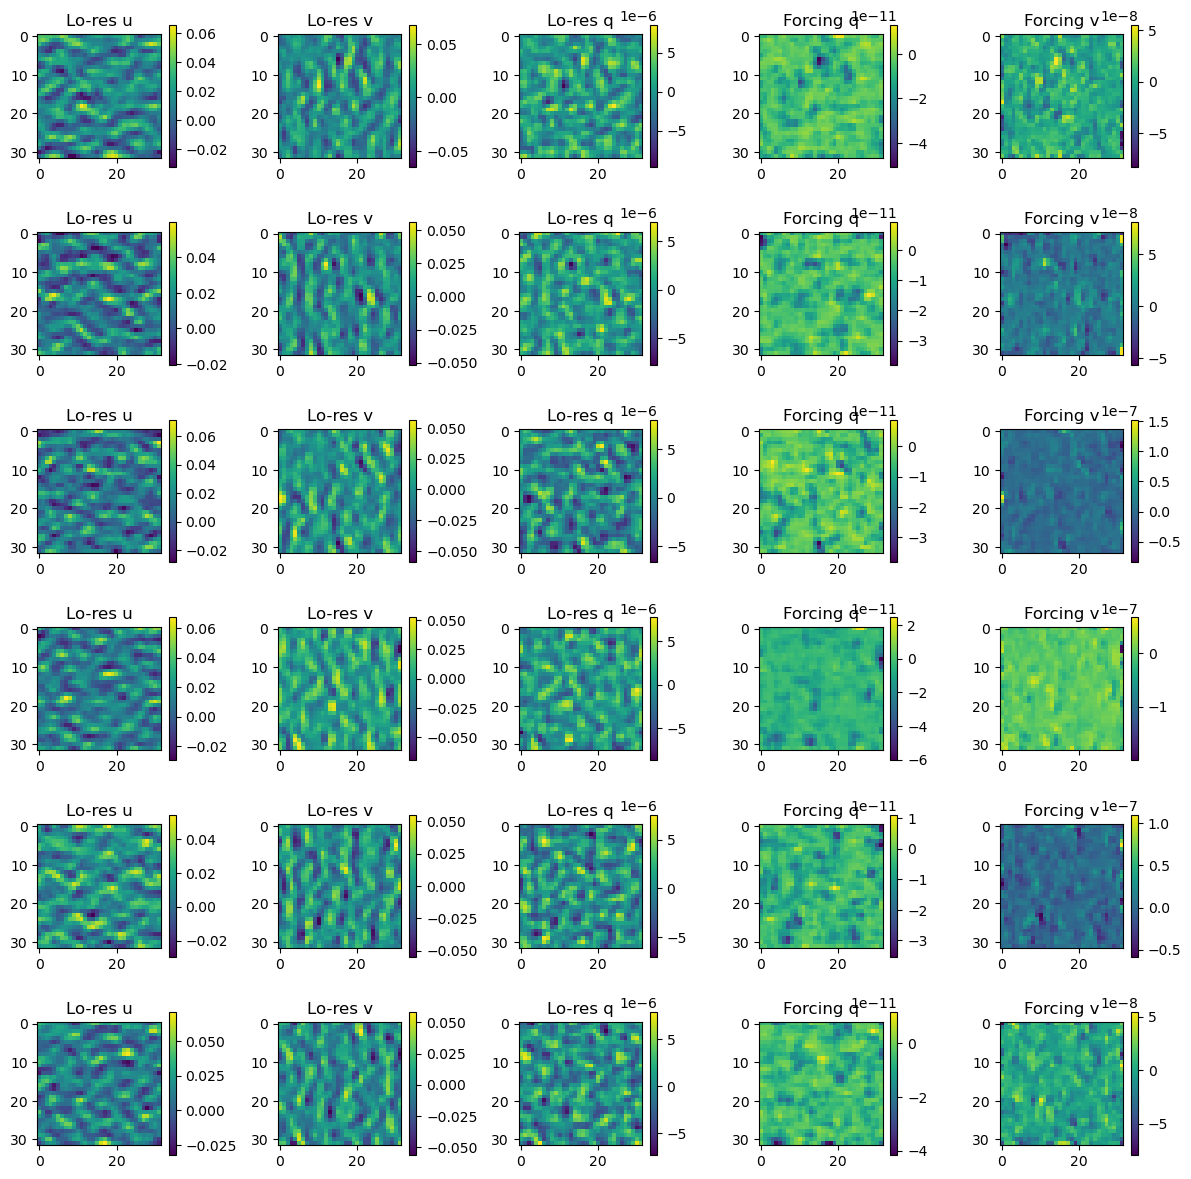

In [12]:
from figure_grid import *
def imshow(x):
    try:
        plt.imshow(x)
    except:
        plt.imshow(x.reshape(32,32))
    plt.colorbar()

order = np.arange(len(uv))
np.random.shuffle(order)

with figure_grid(6,5,rowwidth=12,rowheight=2) as g:
    for i in range(g.rows):
        g.next(title='Lo-res u')
        imshow(u[order[i]])
        g.next(title='Lo-res v')
        imshow(v[order[i]])
        g.next(title='Lo-res q')
        imshow(q[order[i]])
        
        g.next(title='Forcing q')
        imshow(Sq[order[i]])
        g.next(title='Forcing v')
        imshow(Sv[order[i]])

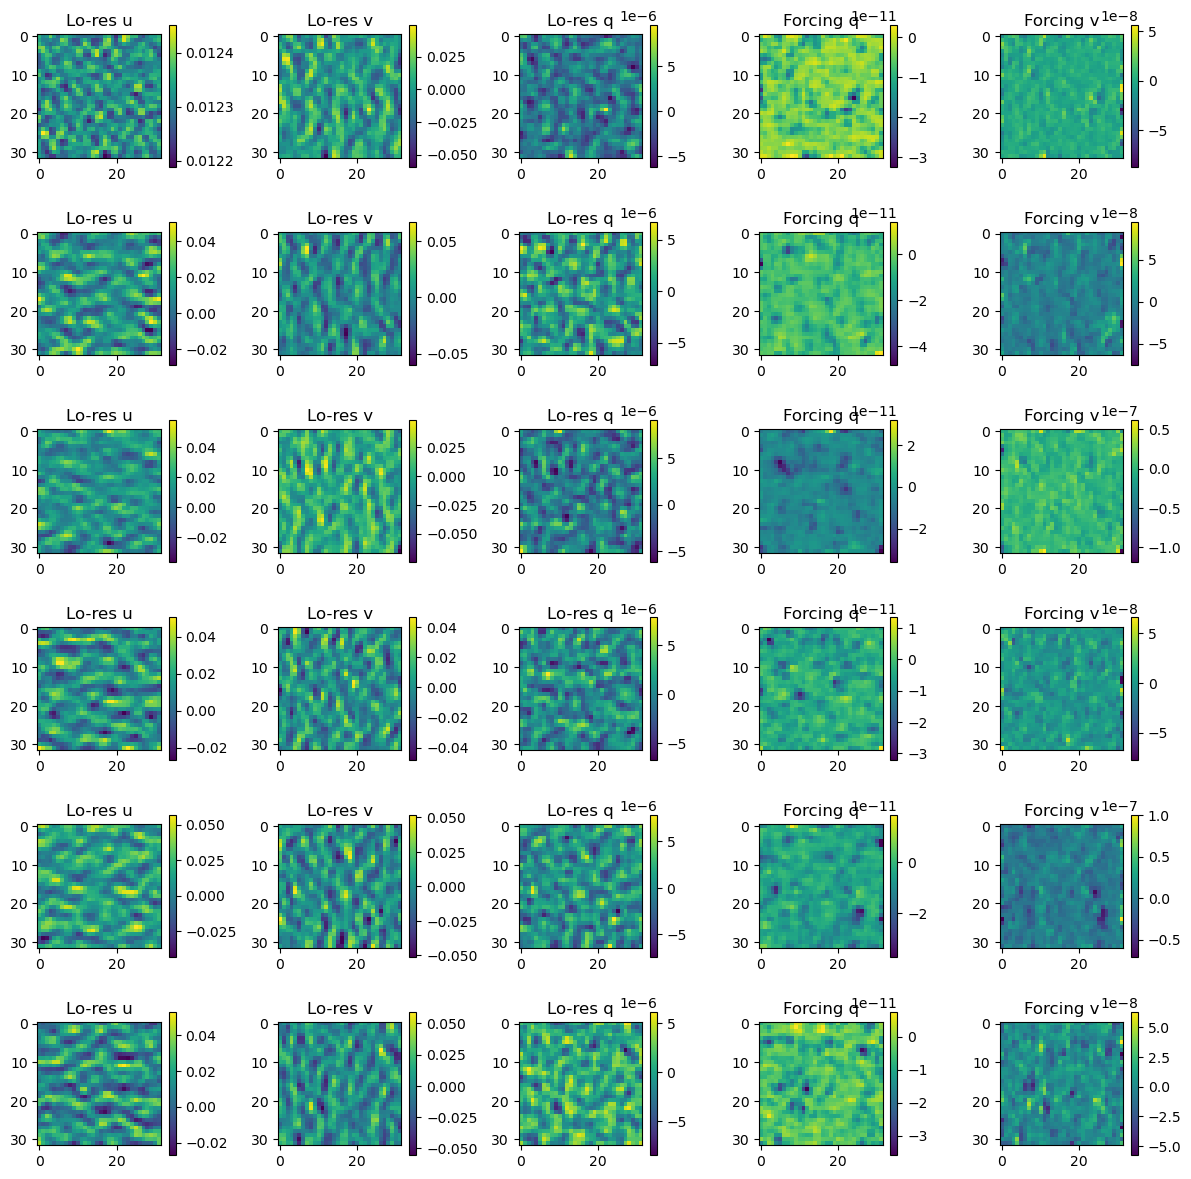

In [64]:
with figure_grid(6,5,rowwidth=12,rowheight=2) as g:
    for i in range(g.rows):
        g.next(title='Lo-res u')
        imshow(u2[order[i]])
        g.next(title='Lo-res v')
        imshow(v2[order[i]])
        g.next(title='Lo-res q')
        imshow(q2[order[i]])
        
        g.next(title='Forcing q')
        imshow(Sq2[order[i]])
        g.next(title='Forcing v')
        imshow(Sv2[order[i]])

In [66]:
u.mean(), u2.mean()

(<xarray.DataArray 'x_velocity' ()>
 array(0.01267993),
 <xarray.DataArray 'x_velocity' ()>
 array(0.01232003))

In [67]:
Sq.mean(), Sq2.mean()

(<xarray.DataArray 'potential_vorticity' ()>
 array(-5.82724714e-12),
 <xarray.DataArray 'potential_vorticity' ()>
 array(-5.69300753e-12))

In [17]:
def train(net, inputs, targets, num_epochs=50, batch_size=64, learning_rate=0.001):
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        epoch_steps = 0
        for x, y in minibatch(inputs, targets, batch_size=batch_size):
            optimizer.zero_grad()
            yhat = net(x)
            loss = criterion(yhat, y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            epoch_steps += 1
            if epoch_steps % 10 == 0:
                print(loss.item())
        print(f"Loss after Epoch {epoch+1}: {epoch_loss/epoch_steps}")

In [46]:
cnn = LargerCNN((2,32,32),(1,32,32))
X_scale = BasicScaler(X.mean(), X.std()/10)
Y_scale = BasicScaler(Y.mean(), Y.std()/10)
cnn.set_scales(X_scale, Y_scale)

N = 35000
train(cnn, X_scale.transform(X[:N]), Y_scale.transform(Y[:N]), learning_rate=0.001)

97.11101531982422
98.072998046875
101.7229232788086
96.39678955078125
100.83173370361328
98.79602813720703
96.7205810546875
96.7874526977539
95.18175506591797
94.73420715332031
97.21771240234375
93.4793472290039
88.47859954833984
94.56651306152344
92.13158416748047
91.37255859375
89.427734375
89.44807434082031
86.84945678710938
87.89840698242188
87.82853698730469
90.8646469116211
82.64019775390625
83.88517761230469
89.84729766845703
82.66537475585938
81.8414535522461
81.7897720336914
80.52172088623047
79.63191223144531
83.71141815185547
78.70059204101562
81.46806335449219
81.33563995361328
78.2895736694336
79.00011444091797
75.92735290527344
75.66098022460938
79.94195556640625
76.94441986083984
75.53064727783203
78.48043060302734
76.23648071289062
76.22754669189453
75.2147216796875
72.21498107910156
75.64241027832031
76.69027709960938
76.90918731689453
76.18214416503906
75.19194030761719
75.59210205078125
74.33543395996094
72.33058166503906
Loss after Epoch 1: 85.06800775336173
73.6626

57.636474609375
58.847442626953125
56.552452087402344
54.90560531616211
57.761016845703125
56.9492073059082
60.643836975097656
57.07084274291992
57.188743591308594
59.35621643066406
56.65391540527344
57.062713623046875
57.433013916015625
58.155845642089844
57.38208770751953
56.32271194458008
59.349544525146484
57.16865539550781
57.647125244140625
56.806419372558594
58.08839416503906
59.04115295410156
57.51162338256836
57.328163146972656
57.02412796020508
59.48870086669922
57.891746520996094
56.805328369140625
58.47698974609375
55.86152267456055
57.47975158691406
56.25151062011719
56.000244140625
56.63843536376953
58.28334426879883
57.785064697265625
59.55363082885742
59.50096893310547
55.91035842895508
58.47239685058594
58.86721420288086
58.74098587036133
58.235652923583984
57.973045349121094
57.039241790771484
59.38326644897461
56.438507080078125
57.82330322265625
Loss after Epoch 9: 57.61321551446723
54.44959259033203
56.24739074707031
54.90162658691406
59.66584014892578
58.155261993

56.603607177734375
54.88762664794922
55.98617935180664
57.6506462097168
56.30680465698242
55.457462310791016
54.22858428955078
57.5638542175293
59.916053771972656
56.9793701171875
56.19965362548828
55.195640563964844
57.031761169433594
56.07268524169922
57.119850158691406
56.26715850830078
56.760414123535156
58.085235595703125
56.881980895996094
58.076637268066406
54.50341033935547
57.84962844848633
57.75
57.212459564208984
55.25290298461914
57.36048126220703
58.21025466918945
56.56418228149414
59.08057403564453
57.49828338623047
56.790611267089844
55.06517028808594
57.409149169921875
56.24592208862305
55.8736572265625
59.0625
55.52305603027344
56.36419677734375
54.901641845703125
56.41257095336914
56.11162567138672
55.163177490234375
57.5516471862793
55.95994186401367
59.05806350708008
56.07933044433594
Loss after Epoch 17: 56.886779589888384
56.15122604370117
59.226619720458984
56.332794189453125
56.24474334716797
56.15325927734375
56.33491134643555
57.506866455078125
59.289638519287

57.167808532714844
59.894020080566406
56.74387741088867
56.947967529296875
57.566505432128906
55.66366958618164
58.1136474609375
57.41942596435547
56.06278610229492
58.14801788330078
57.463134765625
56.644771575927734
57.2573127746582
55.53209686279297
57.46443557739258
55.40169143676758
55.08808898925781
57.258689880371094
56.384281158447266
57.14286804199219
55.73420715332031
55.50729751586914
55.408329010009766
55.880027770996094
55.62580490112305
54.107521057128906
57.2518310546875
56.54421615600586
57.85725402832031
58.51654052734375
57.34248352050781
59.18186950683594
57.310726165771484
58.67915725708008
52.60922622680664
54.009464263916016
58.79169464111328
56.08201599121094
57.50346374511719
56.15229415893555
57.45494842529297
54.73101043701172
54.263004302978516
Loss after Epoch 25: 56.61696769811989
56.600563049316406
56.70980453491211
55.082366943359375
55.17195510864258
55.844940185546875
53.91044998168945
57.48833084106445
55.494354248046875
56.71735382080078
54.6732139587

KeyboardInterrupt: 

In [54]:
N = 35000
train(cnn, X_scale.transform(X[:N]), Y_scale.transform(Y[:N]), learning_rate=0.0001)

56.88341522216797
57.49378204345703
56.019386291503906
56.23902893066406
53.84538650512695
55.04497146606445
55.584083557128906
57.42655563354492
57.031524658203125
57.625160217285156
58.018558502197266
56.267608642578125
53.835697174072266
55.45536804199219
54.270606994628906
55.24254608154297
54.615264892578125
54.88524627685547
54.11439895629883
57.08354949951172
55.19075393676758
55.2280158996582
56.219444274902344
55.49616241455078
56.32098388671875
52.862098693847656
56.856834411621094
55.842010498046875
54.92555618286133
55.4693603515625
55.7322998046875
56.92844009399414
54.428802490234375
56.95915985107422
55.44493865966797
55.472434997558594
53.92505645751953
54.865692138671875
54.749820709228516
58.06517791748047
55.040462493896484
57.60078430175781
55.12939453125
55.11573028564453
56.693965911865234
56.50327682495117
56.70250701904297
54.58646011352539
55.85124588012695
55.61721420288086
57.58509826660156
55.05509948730469
56.957298278808594
56.21547317504883
Loss after Epo

KeyboardInterrupt: 

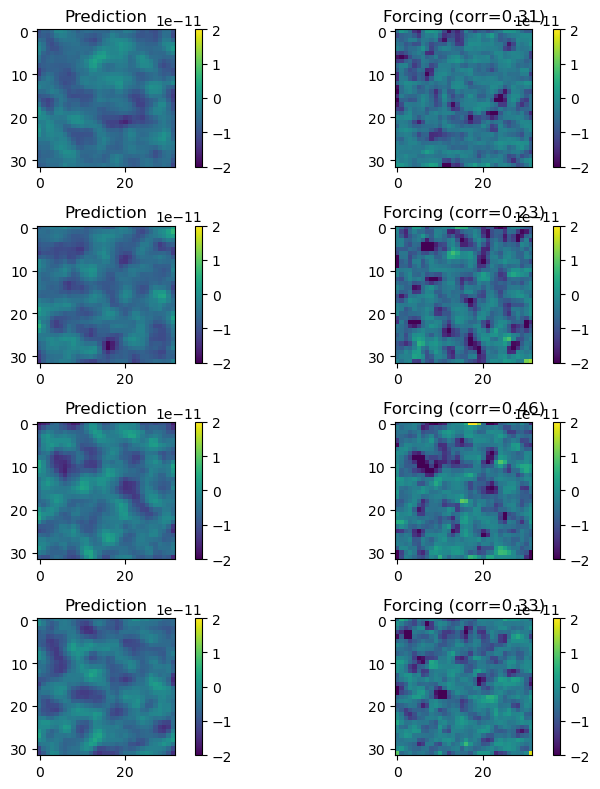

In [56]:
order = np.arange(len(X))[N:]
np.random.shuffle(order)

preds = cnn.predict(X[order[:20]])
    
def imshow(x, **kw):
    try:
        plt.imshow(x, **kw)
    except:
        plt.imshow(x.reshape(32,32), **kw)
    plt.colorbar()
    
with figure_grid(4,2,rowwidth=8,rowheight=2) as g:
    for i in range(g.rows):
        #g.next(title='Hi-res')
        #imshow(hires[N+i])
        #g.next(title='Lo-res')
        #imshow(X[order[i]])
        g.next(title='Prediction')
        imshow(preds[i], vmin=-2e-11, vmax=2e-11)
        corr = pearsonr(preds[i], Y[order[i]])[0]
        g.next(title=f"Forcing (corr={corr:.2f})")
        imshow(Y[order[i]], vmin=-2e-11, vmax=2e-11)
        
        


In [51]:
from scipy.stats import pearsonr

In [52]:
pearsonr(preds[i],Y[order[i]])

(0.41664382136244943, 2.8954989748144766e-44)

In [162]:
predicted_means = []

def q_parameterization(pyqg_run):
    #q = pyqg_run.q.reshape(-1,32*32)

    uv = np.array([
        np.array([u,v]).reshape(2*32*32)
        for u,v in zip(pyqg_run.ufull, pyqg_run.vfull)
    ])
    
    # Just apply to the layer we trained on
    uv = np.array([uv[0]])
    pred = cnn.predict(uv.astype(np.float32))[0]
    dq = np.array([pred, np.zeros_like(pred)])
    
    dq = dq.reshape(pyqg_run.q.shape).astype(uv.dtype)
    predicted_means.append(dq.mean())
    return dq

In [163]:
year = 24*60*60*360.
kwargs = dict(tmax=10*year, twrite=10000, tavestart=5*year, nx=32, q_parameterization=q_parameterization)
m = pyqg.QGModel(**kwargs)

INFO:  Logger initialized


In [164]:
m.run()

INFO: Step: 10000, Time: 7.20e+07, KE: 1.85e-03, CFL: 0.074
INFO: Step: 20000, Time: 1.44e+08, KE: 1.80e-03, CFL: 0.079
INFO: Step: 30000, Time: 2.16e+08, KE: 2.77e-03, CFL: 0.076
INFO: Step: 40000, Time: 2.88e+08, KE: 1.92e-03, CFL: 0.076


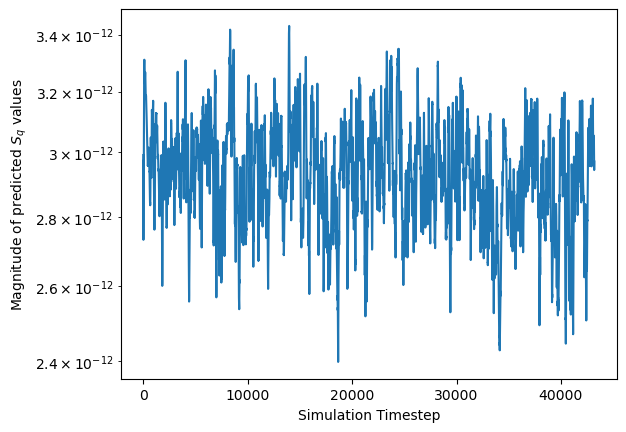

In [165]:
plt.plot(np.abs(predicted_means))
plt.yscale('log')
plt.xlabel("Simulation Timestep")
plt.ylabel("Magnitude of predicted $S_q$ values")
plt.show()

In [166]:
from pyqg.diagnostic_tools import calc_ispec

def plot_kespec(m, i, label=None, show_line=False):
    KE1spec = m.get_diagnostic('KEspec')[i]
    k, KE1spec = calc_ispec(m, KE1spec)
    ax1 = plt.gca()
    ax1.loglog(k, KE1spec, '.-', label=label)
    ax1.set_xlabel(r'$\kappa$ (m$^{-1})$')
    ax1.set_ylabel(r'$m^3 s^{-2}$')
    if show_line:
        ir = np.r_[10:20]
        ax1.loglog(k[10:20], 2 * (k[ir] ** -3) *
               KE1spec[ir].mean() / (k[ir] ** -3).mean(),
               '0.5', label='$\propto k^{-3}$')

In [169]:
year = 24*60*60*360.
kwargs = dict(tmax=10*year, twrite=10000, tavestart=5*year)
m2 = pyqg.QGModel(**kwargs)
m2.run()

INFO:  Logger initialized
INFO: Step: 10000, Time: 7.20e+07, KE: 6.28e-04, CFL: 0.107
INFO: Step: 20000, Time: 1.44e+08, KE: 4.56e-04, CFL: 0.091
INFO: Step: 30000, Time: 2.16e+08, KE: 5.07e-04, CFL: 0.092
INFO: Step: 40000, Time: 2.88e+08, KE: 4.40e-04, CFL: 0.087


In [170]:
year = 24*60*60*360.
kwargs = dict(tmax=10*year, twrite=10000, tavestart=5*year, nx=32)
m3 = pyqg.QGModel(**kwargs)
m3.run()

INFO:  Logger initialized
INFO: Step: 10000, Time: 7.20e+07, KE: 5.68e-04, CFL: 0.041
INFO: Step: 20000, Time: 1.44e+08, KE: 6.39e-04, CFL: 0.043
INFO: Step: 30000, Time: 2.16e+08, KE: 6.47e-04, CFL: 0.040
INFO: Step: 40000, Time: 2.88e+08, KE: 6.47e-04, CFL: 0.040


In [171]:
m.ke, m2.ke, m3.ke

(0.0019156671469083215, 0.00044030895768657873, 0.000647119718452523)

In [ ]:

plot_kespec(m3, 0, label='nx=32')
plot_kespec(m, 0, label='nx=32, parameterized')
plot_kespec(m2, 0, label='nx=64', show_line=True)
plt.title('Kinetic Energy Spectrum')
plt.legend()
plt.show()